In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import canny
from skimage.segmentation import felzenszwalb, mark_boundaries
import geopandas as gpd
from scipy.signal import savgol_filter
from datetime import datetime
import plotly.express as px
from scipy.ndimage import generic_filter

from skimage.filters import gaussian

np.set_printoptions(suppress=True) 
gdf = gpd.read_file("PASTIS/metadata.geojson")

In [2]:
def nan_mean_filter(image, size=3):
    def mean_filter(values):
        center_value = values[len(values) // 2]
        if np.isnan(center_value):
            valid_values = values[~np.isnan(values)]
            if len(valid_values) == 0:
                return np.nan
            else:
                return np.mean(valid_values)
        else:
            return center_value

    filled_image = image.copy()
    
    filled_image = generic_filter(filled_image, mean_filter, size=size, mode='constant', cval=np.nan)

    return filled_image

In [3]:
RGB_COLOR = [2, 1, 0]
AGRI_COLOR = [6, 8, 2]
EVI2_COLOR = [10]

In [258]:
def get_images_and_dates(iloc: int):
    def dates_to_days(dates):
        dates = [str(date) for date in dates]
        date_objs = [datetime.strptime(date, "%Y%m%d") for date in dates]
        days_diff = [(date - date_objs[0]).days for date in date_objs]
        days_diff_array = np.array(days_diff)

        return days_diff_array + 1

    sample_id = gdf.iloc[iloc].ID_PATCH
    dates = dates_to_days(list(gdf.iloc[iloc]["dates-S2"].values()))

    ts = np.load(f"PASTIS/DATA_S2/S2_{sample_id}.npy")
    ts = np.moveaxis(ts, 1, -1)

    ts = np.clip((ts / 10000) * np.pi, 0, 1)

    # cloud removal
    ts[ts[:, :, :, 0] > 0.5] = np.nan  # blue band cut (for cloud detection)
    ts[ts[:, :, :, 6] < 0.3] = np.nan  # nir band cut (for cloud shadow)

    keeped = np.isnan(ts).mean(axis=(1, 2, 3)) < 0.3
    dates = dates[keeped]
    ts = ts[keeped]

    # first image cloud imputation
    first_img_nan_mask = np.isnan(ts[0])
    ts[0][first_img_nan_mask] = np.take(
        np.nanmean(ts[0], axis=(0, 1)), np.where(first_img_nan_mask)[-1]
    )

    # other images cloud imputation
    for i in range(1, ts.shape[0]):
        nan_mask = np.isnan(ts[i])
        ts[i][nan_mask] = ts[i - 1][nan_mask]

    # smoothing bands
    ts = savgol_filter(ts, window_length=11, polyorder=3, axis=0)

    # adding EVI2
    NIR = ts[:, :, :, 6]
    RED = ts[:, :, :, 2]
    EVI2 = 2.5 * (NIR - RED) / (NIR + 2 * RED + 1)
    ts = np.concatenate((ts, EVI2[:, :, :, np.newaxis]), axis=-1)

    # keeping values between 0 and 1
    ts = np.clip(ts, 0, 1)

    return ts, dates

In [275]:
def plot_images_and_dates(ts, dates, color=EVI2_COLOR):
    plots_per_row = min(8, np.ceil(ts.shape[0] / 2).astype(int))
    rows = np.ceil(ts.shape[0] / plots_per_row).astype(int)
    fig, axs = plt.subplots(rows, plots_per_row, figsize=(plots_per_row * 4, rows * 3))

    for row in range(rows):
        for col in range(plots_per_row):
            axs[row, col].set_xticks([])
            axs[row, col].set_yticks([])

            abs_index = row * plots_per_row + col

            if abs_index < ts.shape[0]:
                axs[row, col].imshow(ts[abs_index][:, :, color])
                axs[row, col].set_title(f"ts={dates[abs_index]}, EVI2={ts[abs_index, :, :, 10].mean():.2f}")
            else:
                fig.delaxes(axs[row, col])

In [381]:
def base_ids_to_img(base):
    img = np.zeros((*(base.shape),3), dtype=np.uint8)

    uniques = np.unique(base)
    for unique_id in uniques[(uniques != 0) & (uniques != -1)]:
        colors = np.random.randint(40, 220, size=(3), dtype=np.uint8)
        white = np.array([255, 255, 255], dtype=np.uint8)

        img[np.where(base==unique_id)] = colors
        img[np.where(base==-1)] = white
    return img

def plot_reference_segmentations(iloc: int, ax=None):
    sample_id = gdf.iloc[iloc].ID_PATCH
    segmentation = np.load(f"PASTIS/ANNOTATIONS/ParcelIDs_{sample_id}.npy")

    # ax.imshow(canny(segmentation / np.max(segmentation), sigma=1), cmap=plt.cm.gray)
    img = base_ids_to_img(segmentation)
    ax.imshow(img)

In [7]:
def extract_features(ts, dates):
    def get_single_band_from_indices(ts, indices, band_number):
        draw = np.empty((128, 128), dtype=np.float32)
        for i in range(128):
            for j in range(128):
                draw[i, j] = ts[indices[i, j], i, j, band_number]

        return draw

    def replace_zeros_with_ones(array):
        array[array == 0] = 1
        return array

    evi2_argmax = np.argmax(ts[:, :, :, EVI2_COLOR], axis=0).squeeze()

    vp_dates = dates[evi2_argmax]
    evi2_max = np.max(ts[:, :, :, EVI2_COLOR], axis=0).squeeze()
    evi2_min = np.min(ts[:, :, :, EVI2_COLOR], axis=0).squeeze()

    vp_blue = get_single_band_from_indices(ts, evi2_argmax, 0)
    vp_green = get_single_band_from_indices(ts, evi2_argmax, 1)
    vp_red = get_single_band_from_indices(ts, evi2_argmax, 2)
    vp_re1 = get_single_band_from_indices(ts, evi2_argmax, 3)
    vp_re2 = get_single_band_from_indices(ts, evi2_argmax, 4)
    vp_re3 = get_single_band_from_indices(ts, evi2_argmax, 5)
    vp_nir = get_single_band_from_indices(ts, evi2_argmax, 6)
    vp_re4 = get_single_band_from_indices(ts, evi2_argmax, 7)
    vp_swir1 = get_single_band_from_indices(ts, evi2_argmax, 8)
    vp_swir2 = get_single_band_from_indices(ts, evi2_argmax, 9)

    sen_ratio = vp_dates / np.max(vp_dates)

    evi2_gain = (evi2_max - ts[0, :, :, EVI2_COLOR].squeeze()) / vp_dates
    evi2_loss = (evi2_max - ts[-1, :, :, EVI2_COLOR].squeeze()) / (
        replace_zeros_with_ones(np.max(dates) - vp_dates)
    )

    return np.stack(
        [
            sen_ratio,
            evi2_gain,
            evi2_loss,
            evi2_max,
            evi2_min,
            vp_blue,
            vp_green,
            vp_red,
            vp_re1,
            vp_re2,
            vp_re3,
            vp_nir,
            vp_re4,
            vp_swir1,
            vp_swir2,
        ],
        axis=-1,
    )

In [8]:
def calculate_euclidean_distance(image: np.ndarray, position1: float, position2: float) -> float:
    bands_pixel1 = image[position1]
    bands_pixel2 = image[position2]
    
    distance = np.linalg.norm(bands_pixel1 - bands_pixel2)
    
    return distance

def bfs_border_detection(features: np.ndarray, distance_threshold: float = 0.15) -> np.ndarray:
    def get_neighbors(i, j):
        moves = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        moves = [(i + x, j + y) for x, y in moves]
        moves = list(filter(lambda x: 0 <= x[0] < features.shape[0] and 0 <= x[1] < features.shape[1], moves))
        return moves

    visited = np.zeros((features.shape[0], features.shape[1]), dtype=bool)
    skeleton = np.zeros((features.shape[0], features.shape[1]), dtype=bool)

    def bfs_from_a_point(x, y):
        stack = [(x, y)]
        visited[x, y] = True

        while stack:
            x, y = stack.pop()

            for i, j in get_neighbors(x, y):
                if not visited[i, j]:
                    if calculate_euclidean_distance(features, (x, y), (i, j)) < distance_threshold:
                        stack.append((i, j))
                    else:
                        skeleton[i, j] = True 
                    visited[i, j] = True

    while (~visited).any():
        indexes = np.where(~visited)
        bfs_from_a_point(indexes[0][0], indexes[1][0])

    return skeleton

def bfs_less_noise_border_detection(features: np.ndarray, distance_threshold: float = 0.15, min_pixels_to_be_a_region: int = 20) -> np.ndarray:
    steps = []

    def get_neighbors(i, j):
        moves = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        moves = [(i + x, j + y) for x, y in moves]
        moves = list(filter(lambda x: 0 <= x[0] < features.shape[0] and 0 <= x[1] < features.shape[1], moves))
        return moves

    visited = np.zeros((features.shape[0], features.shape[1]), dtype=bool)
    skeleton = np.zeros((features.shape[0], features.shape[1]), dtype=bool)

    def bfs_from_a_point(x, y):
        stack = [(x, y)]
        visited[x, y] = True
        sub_skeleton = np.zeros((features.shape[0], features.shape[1]), dtype=bool)

        while stack:
            x, y = stack.pop()

            for i, j in get_neighbors(x, y):
                if not visited[i, j]:
                    if calculate_euclidean_distance(features, (x, y), (i, j)) < distance_threshold:
                        stack.append((i, j))
                    else:
                        sub_skeleton[i, j] = True 
                    visited[i, j] = True

        if sub_skeleton.sum() > min_pixels_to_be_a_region:
            skeleton[sub_skeleton] = True
            steps.append(skeleton.copy())

    while (~visited).any():
        indexes = np.where(~visited)
        random_index_of_indexes = np.random.randint(0, len(indexes[0]))
        bfs_from_a_point(indexes[0][random_index_of_indexes], indexes[1][random_index_of_indexes])

    return skeleton, np.stack(steps)

In [386]:
def bfs_less_noise_border_detection(features: np.ndarray, distance_threshold: float = 0.15, min_pixels_to_be_a_region: int = 20) -> np.ndarray:
    steps = []

    def get_neighbors(i, j):
        moves = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        moves = [(i + x, j + y) for x, y in moves]
        moves = list(filter(lambda x: 0 <= x[0] < features.shape[0] and 0 <= x[1] < features.shape[1], moves))
        return moves

    visited = np.zeros((features.shape[0], features.shape[1]), dtype=bool)
    skeleton = np.zeros((features.shape[0], features.shape[1]), dtype=int)

    def bfs_from_a_point(x, y, id, skeleton):
        stack = [(x, y)]
        visited[x, y] = True
        sub_skeleton = np.zeros((features.shape[0], features.shape[1]), dtype=int)

        while stack:
            x, y = stack.pop()

            for i, j in get_neighbors(x, y):
                if not visited[i, j]:
                    if calculate_euclidean_distance(features, (x, y), (i, j)) < distance_threshold:
                        sub_skeleton[i, j] = id
                        stack.append((i, j))
                    visited[i, j] = True

        if (sub_skeleton==id).sum() > min_pixels_to_be_a_region:
            skeleton += sub_skeleton
            steps.append(skeleton.copy())

    id = 1
    while (~visited).any():
        indexes = np.where(~visited)
        random_index_of_indexes = np.random.randint(0, len(indexes[0]))
        bfs_from_a_point(indexes[0][random_index_of_indexes], indexes[1][random_index_of_indexes], id, skeleton)
        id += 1

    return base_ids_to_img(skeleton), base_ids_to_img(np.array(steps))

In [337]:
def plot_images_animation(images, title=""):
    fig = px.imshow(images, animation_frame=0, binary_string=True, binary_compression_level=1, labels={'animation_frame': 'Step'})
    fig.update_layout(title=title)
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    fig.show()

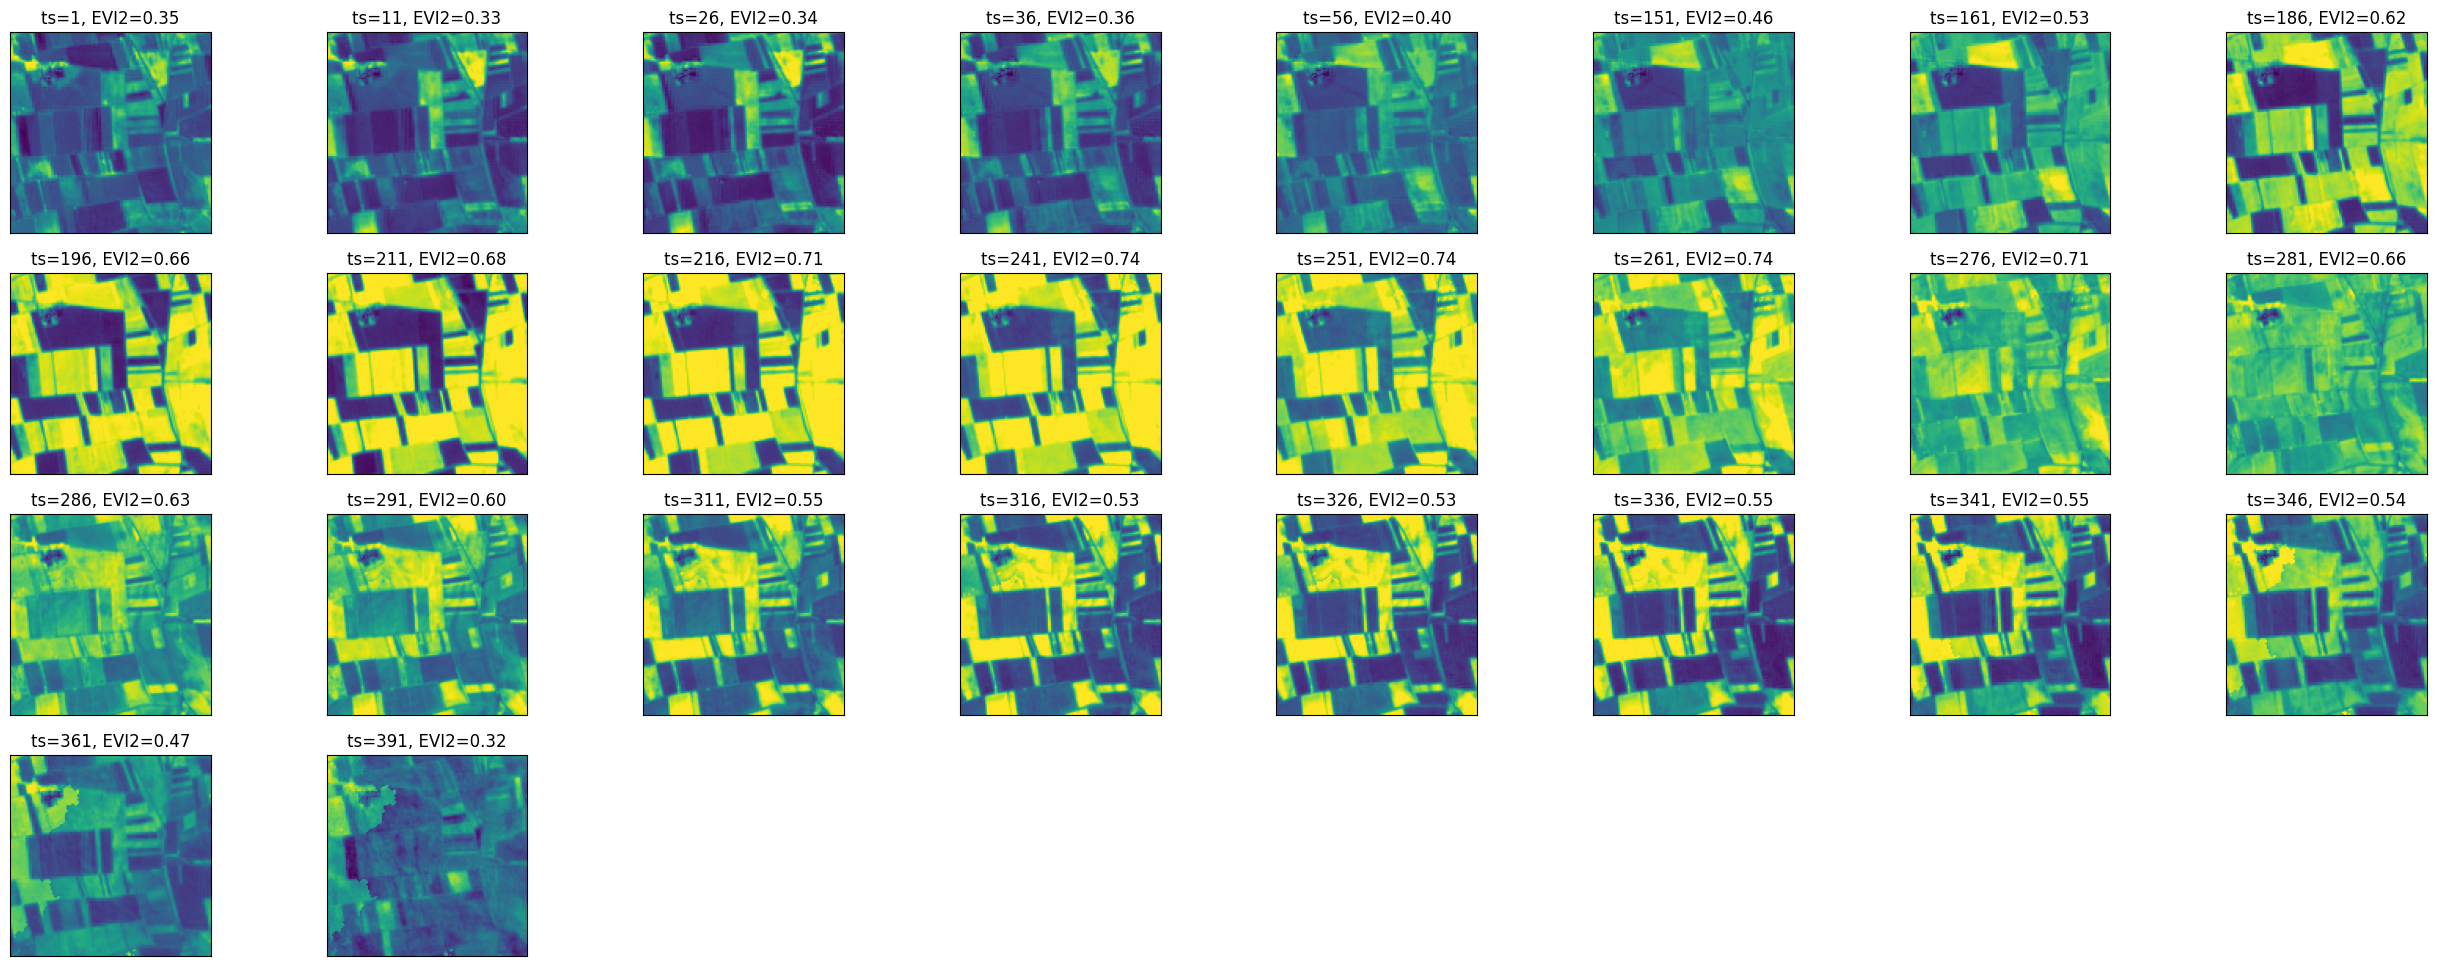

In [328]:
# 0, 2, 5, 2000, 2001

iloc = 2000
ts, dates = get_images_and_dates(iloc)
plot_images_and_dates(ts, dates)

features = extract_features(ts, dates)

/tmp/ipykernel_75255/1367434406.py:11: RuntimeWarning:

Got image with third dimension of 15. This image will be interpreted as a multichannel 2d image, which may not be intended.



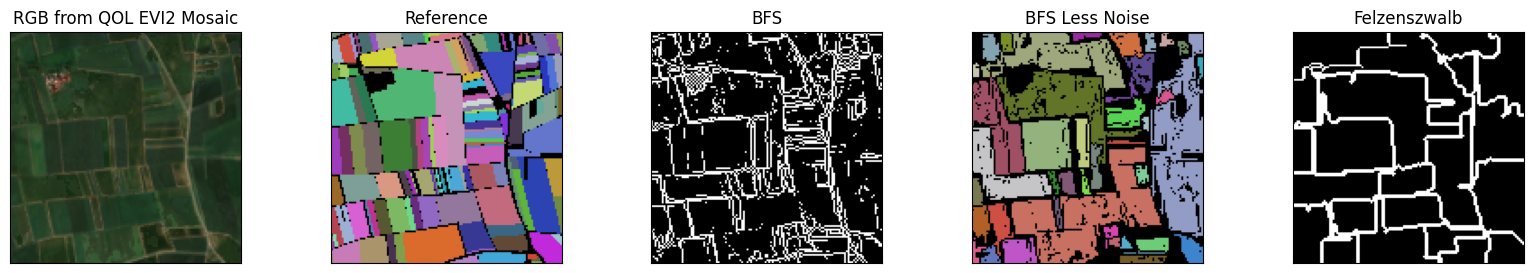

In [390]:
_, ax = plt.subplots(1, 5, figsize=(5*4, 3))

for aax in ax:
    aax.set_xticks([])
    aax.set_yticks([])

ax[0].imshow(features[:,:,[7,6,5]]*1.3)
plot_reference_segmentations(iloc, ax[1])
ax[2].imshow(bfs_border_detection(features, 0.15), cmap=plt.cm.gray)
ax[3].imshow(bfs_less_noise_border_detection(features, 0.12, 20)[0])
ax[4].imshow(mark_boundaries(np.zeros((128,128,3)), felzenszwalb(features, scale=3.0, sigma=1, min_size=200), color=(1,1,1)))

ax[0].title.set_text("RGB from QOL EVI2 Mosaic")
ax[1].title.set_text("Reference")
ax[2].title.set_text("BFS")
ax[3].title.set_text("BFS Less Noise")
ax[4].title.set_text("Felzenszwalb")

In [387]:
plot_images_animation(bfs_less_noise_border_detection(features, 0.12, 20)[1], title="BFS Less Noise All Features")

In [371]:
base = bfs_less_noise_border_detection(features, 0.12, 20)[1]

In [374]:

img = np.zeros((*(base.shape),3), dtype=np.uint8)

uniques = np.unique(base)
for unique_id in uniques[(uniques != 0) & (uniques != -1)]:
    colors = np.random.randint(40, 220, size=(3), dtype=np.uint8)
    img[np.where(base==unique_id)] = colors


In [377]:
base.shape

(43, 128, 128)

array([  1,   4,   5,   6,   7,   8,  10,  11,  12,  13,  14,  15,  16,
        19,  20,  21,  22,  23,  25,  29,  35,  38,  39,  42,  43,  45,
        51,  57,  58,  71,  72,  76,  80,  81,  84,  88,  93,  98, 110,
       122, 123, 168, 210])

In [241]:
def calculate_all_diffs_neighboors(img):
    H, W, _ = img.shape
    diffs = []

    for i in range(H):
        for j in range(W):
            central_pixel = img[i, j]
            neighboors = []

            if i > 0:
                neighboors.append((i-1, j))
                if j > 0:
                    neighboors.append((i-1, j-1))
                if j < W-1:
                    neighboors.append((i-1, j+1))

            if j > 0:
                neighboors.append((i, j-1))
            if j < W-1:
                neighboors.append((i, j+1))
            
            if i < H-1:
                neighboors.append((i+1, j))
                if j > 0:
                    neighboors.append((i+1, j-1))
                if j < W-1:
                    neighboors.append((i+1, j+1))

            for x, y in neighboors:
                neighboor_pixel = img[x, y]
                diffs.append([i, j, x, y, np.linalg.norm(central_pixel - neighboor_pixel), *(np.abs(central_pixel - neighboor_pixel))])


    return np.array(diffs)

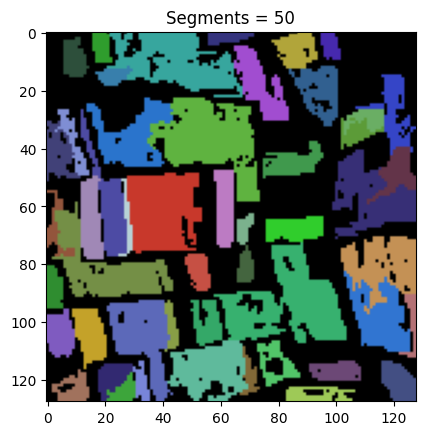

In [353]:
diffs = calculate_all_diffs_neighboors(features)[:, :5]
diffs = diffs[np.argsort(diffs[:, 4])]

base = np.arange(128*128, dtype=np.int16).reshape(128,128)
np.random.shuffle(base)
base = base.reshape(128,128)

for diff in diffs[diffs[:, 4] < np.quantile(diffs[:, 4], 0.5)]:
    x0,y0,x1,y1 = np.round(diff[:4]).astype(int)
    
    first_group_id = base[x0, y0]
    second_group_id = base[x1, y1]

    base[base == first_group_id] = second_group_id

# Removing inconsistences
for segment in np.unique(base):
    if np.sum(base == segment) < 40:
        base[base == segment] = 0


img = base_ids_to_img(base)

plt.imshow(img)
plt.title(f"Segments = {len(np.unique(base))-1}")
plt.show()

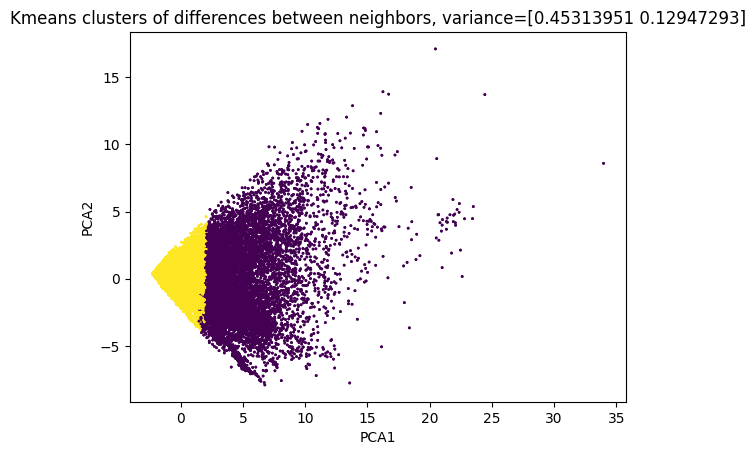

In [279]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca = PCA(n_components=2)
kmeans = KMeans(n_clusters=2)

diffs = calculate_all_diffs_neighboors(features)
X_scaled = scaler.fit_transform(diffs[:, 5:])
X_pca = pca.fit_transform(X_scaled)

kmeans.fit(X_scaled)

X_pca = pca.transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, s=1)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title(f"Kmeans clusters of differences between neighbors, variance={pca.explained_variance_ratio_}")

plt.show()


In [280]:
marks = kmeans.predict(X_scaled)
first_cluster = diffs[marks == 0]
second_cluster = diffs[marks == 1]

In [281]:
np.max(first_cluster[:, 4]), np.max(second_cluster[:, 4])

(1.66031591873922, 1.0150216234169105)

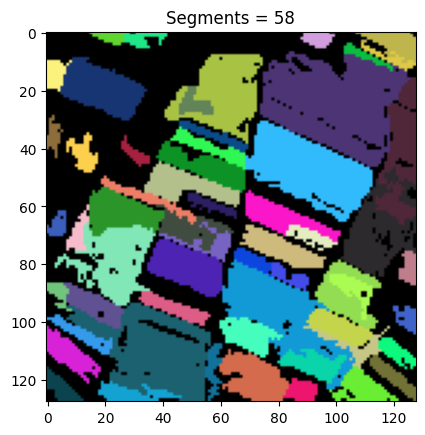

In [282]:
if np.mean(first_cluster[:,4]) < np.mean(second_cluster[:,4]):
    first_cluster, second_cluster = second_cluster, first_cluster

base = np.arange(128*128, dtype=np.int16).reshape(128,128)
np.random.shuffle(base)
base = base.reshape(128,128)

for diff in second_cluster[second_cluster[:, 4] < 0.09]:
    x0,y0,x1,y1 = np.round(diff[:4]).astype(int)
    
    first_group_id = base[x0, y0]
    second_group_id = base[x1, y1]

    base[base == first_group_id] = second_group_id

# Removing inconsistences
for segment in np.unique(base):
    if np.sum(base == segment) < 40:
        base[base == segment] = 0


img = np.zeros((128,128,3), dtype=np.uint8)
for unique_id in np.unique(base)[1:]:
    colors = np.random.randint(10, 255, size=(3), dtype=np.uint8)
    img[np.where(base==unique_id)] = colors

plt.imshow(img)
plt.title(f"Segments = {len(np.unique(base))-1}")
plt.show()

In [284]:
px.imshow(features[:,:,[7,6,5]].squeeze())

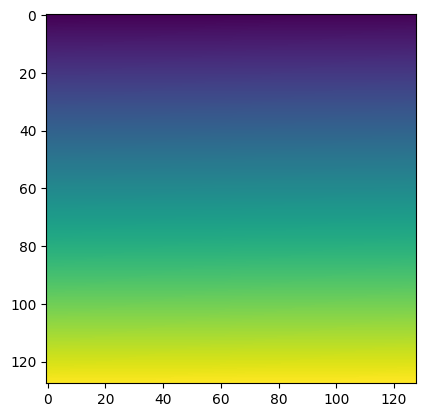

In [19]:
# from numpy import *
# import numpy
# import maxflow
# from PIL import Image
# from matplotlib import pyplot as plt
# from pylab import *
# import cv2

# #The function implements graph cut by partitioning a directed graph into two disjoint sets, foreground and background...
# def graph(file, # input image
# k, # kappa value --> similar pixels have weight close to kappa
# s, # Sigma value --> determines how fast the values decay towards zero with increasing dissimilarity.
# fore, # foreground area ---> should be input by the user manually.
# back): # background area ---> should be input by the user manually.
#     I = (Image.open(file).convert('L')) # read image
#     If = I.crop(fore) # take a part of the foreground
#     Ib = I.crop(back) # take a part of the background
#     I,If,Ib = array(I),array(If),array(Ib) # convert all the images to arrays to calculation
#     Ifmean,Ibmean = mean(cv2.calcHist([If],[0],None,[256],[0,256])),mean(cv2.calcHist([Ib],[0],None,[256],[0,256])) #Taking the mean of the histogram
#     F,B =  ones(shape = I.shape),ones(shape = I.shape) #initalizing the foreground/background probability vector
#     Im = I.reshape(-1,1) #Coverting the image array to a vector for ease.
#     m,n = I.shape[0],I.shape[1]# copy the size
#     g,pic = maxflow.Graph[int](m,n),maxflow.Graph[int]() # define the graph
#     structure = np.array([[inf, 0, 0],
#                           [inf, 0, 0],
#                           [inf, 0, 0]
#                          ]) # initializing the structure....
#     source,sink,J = m*n,m*n+1,I # Defining the Source and Sink (terminal)nodes.
#     nodes,nodeids = g.add_nodes(m*n),pic.add_grid_nodes(J.shape) # Adding non-nodes
#     pic.add_grid_edges(nodeids,0),pic.add_grid_tedges(nodeids, J, 255-J)
#     gr = pic.maxflow()
#     IOut = pic.get_grid_segments(nodeids)
#     for i in range(I.shape[0]): # Defining the Probability function....
#         for j in range(I.shape[1]):
#             F[i,j] = -log(abs(I[i,j] - Ifmean)/(abs(I[i,j] - Ifmean)+abs(I[i,j] - Ibmean))) # Probability of a pixel being foreground
#             B[i,j] = -log(abs(I[i,j] - Ibmean)/(abs(I[i,j] - Ibmean)+abs(I[i,j] - Ifmean))) # Probability of a pixel being background
#     F,B = F.reshape(-1,1),B.reshape(-1,1) # convertingb  to column vector for ease
#     for i in range(Im.shape[0]):
#         Im[i] = Im[i] / linalg.norm(Im[i]) # normalizing the input image vector 
#     w = structure # defining the weight       
#     for i in range(m*n):#checking the 4-neighborhood pixels
#         ws=(F[i]/(F[i]+B[i])) # source weight
#         wt=(B[i]/(F[i]+B[i])) # sink weight
#         g.add_tedge(i,ws[0],wt) # edges between pixels and terminal
#         if i%n != 0: # for left pixels
#             w = k*exp(-(abs(Im[i]-Im[i-1])**2)/s) # the cost function for two pixels
#             g.add_edge(i,i-1,w[0],k-w[0]) # edges between two pixels
#             '''Explaination of the likelihood function: * used Bayes’ theorem for conditional probabilities
#             * The function is constructed by multiplying the individual conditional probabilities of a pixel being either 
#             foreground or background in order to get the total probability. Then the class with highest probability is selected.
#             * for a pixel i in the image:
#                                * weight from sink to i:
#                                probabilty of i being background/sum of probabilities
#                                * weight from source to i:
#                                probabilty of i being foreground/sum of probabilities
#                                * weight from i to a 4-neighbourhood pixel:
#                                 K * e−|Ii−Ij |2 / s
#                                  where k and s are parameters that determine hwo close the neighboring pixels are how fast the values
#                                  decay towards zero with increasing dissimilarity
#             '''
#         if (i+1)%n != 0: # for right pixels
#             w = k*exp(-(abs(Im[i]-Im[i+1])**2)/s)
#             g.add_edge(i,i+1,w[0],k-w[0]) # edges between two pixels
#         if i//n != 0: # for top pixels
#             w = k*exp(-(abs(Im[i]-Im[i-n])**2)/s)
#             g.add_edge(i,i-n,w[0],k-w[0]) # edges between two pixels
#         if i//n != m-1: # for bottom pixels
#             w = k*exp(-(abs(Im[i]-Im[i+n])**2)/s)
#             g.add_edge(i,i+n,w[0],k-w[0]) # edges between two pixels
#     I = array(Image.open(file)) # calling the input image again to ensure proper pixel intensities....
#     print("The maximum flow for %s is %d"%(file,gr)) # find and print the maxflow
#     Iout = ones(shape = nodes.shape)
#     for i in range(len(nodes)):
#         Iout[i] = g.get_segment(nodes[i]) # calssifying each pixel as either forground or background
#     out = 255*ones((I.shape[0],I.shape[1],3)) # initialization for 3d input
#     for i in range(I.shape[0]):
#         for j in range(I.shape[1]): # converting the True/False to Pixel intensity
#             if IOut[i,j]==False:
#                 if len(I.shape) == 2:
#                     out[i,j,0],out[i,j,1],out[i,j,2] = I[i,j],I[i,j],I[i,j] # foreground for 2d image
#                 if len(I.shape) == 3:
#                     out[i,j,0],out[i,j,1],out[i,j,2] = I[i,j,0],I[i,j,1],I[i,j,2] # foreground for 3d image
#             else:
#                 out[i,j,0],out[i,j,1],out[i,j,2] = 1,255,255 # red background 
#     figure()
#     plt.imshow(out,vmin=0,vmax=255) # plot the output image
#     plt.show()

#     return out

# out = graph('input1.jpg',2,100,(225,142,279,185),(7,120,61,163)) #calling the maxflow funtion for input1
# #graph('input2.jpg',2,120,(148,105,201,165),(11,12,80,52)) #calling the maxflow funtion for input2